In [2]:
# https://www.kaggle.com/onestar/kernel-xgboost-stacking
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard#score
import sys
import pandas as pd 
import matplotlib
import numpy as np
import scipy as sp
from IPython import display
import sklearn
import random, time, warnings

In [3]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
# from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [4]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [5]:
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


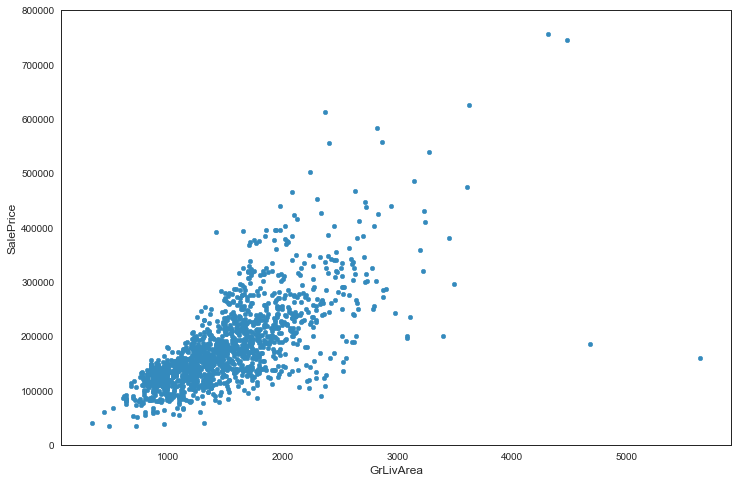

In [6]:
# 去除异常点
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [7]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 200000)].index)
train_df.iloc[7]

Id                    8
MSSubClass           60
MSZoning             RL
LotFrontage         NaN
LotArea           10382
                  ...  
MoSold               11
YrSold             2009
SaleType             WD
SaleCondition    Normal
SalePrice        200000
Name: 7, Length: 81, dtype: object

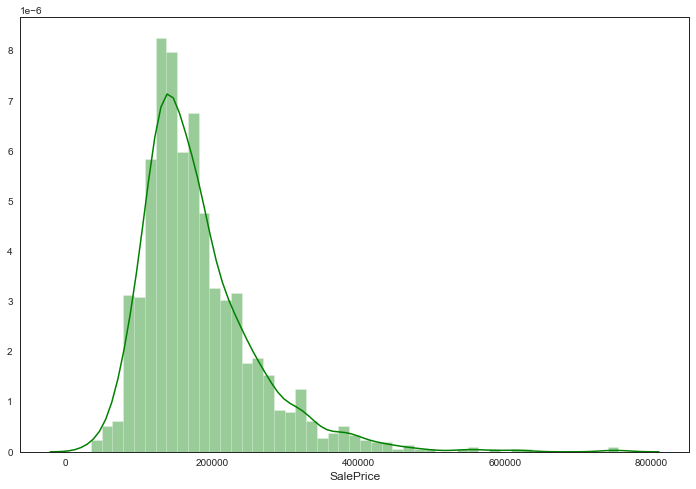

In [8]:
sns.distplot(train_df['SalePrice'], color='green')

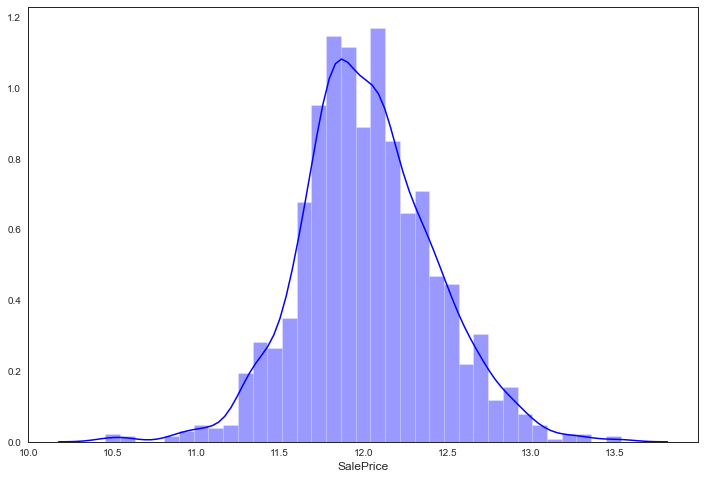

In [9]:
# 预测值倾斜，对数处理
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
sns.distplot(train_df['SalePrice'], color='blue')

In [10]:
from sklearn.preprocessing import LabelEncoder
# categories = [i for i in train_df.columns if i not in cols]
# process columns, apply LabelEncoder to categorical features

numeric_features = list(train_df.dtypes[train_df.dtypes != 'object'].index)
numeric_features.remove('SalePrice')
print(len(numeric_features))
categories_features = list(train_df.dtypes[train_df.dtypes == 'object'].index)
print(len(categories_features))

37
43


In [11]:
for c in categories_features:
    lbl = LabelEncoder() 
    train_df[c] = lbl.fit_transform(list(train_df[c].values))
    test_df[c] = lbl.fit_transform(list(test_df[c].values))


# shape        
print ('Shape all_data: {}'.format(train_df.shape))
print ('Shape all_data: {}'.format(test_df.shape))

Shape all_data: (1458, 81)
Shape all_data: (1459, 80)


In [12]:
# wxz added: 用中位数填充NAN 
train_mean = train_df.median().to_dict()
train_df = train_df.fillna(train_mean)

test_mean = test_df.median().to_dict()
test_df = test_df.fillna(test_mean)

train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,12.247699
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,12.109016
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,12.317171
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,11.849405
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,2,3,3,0,...,0,3,4,4,0,8,2007,8,4,12.072547
1456,1457,20,3,85.0,13175,1,2,3,3,0,...,0,3,2,4,0,2,2010,8,4,12.254868
1457,1458,70,3,66.0,9042,1,2,3,3,0,...,0,3,0,2,2500,5,2010,8,4,12.493133
1458,1459,20,3,68.0,9717,1,2,3,3,0,...,0,3,4,4,0,4,2010,8,4,11.864469


In [13]:
# 特征标准化
from scipy.special import boxcox1p
# skewed_features = list(skewness)
lam = 0.15
for feature in numeric_features:
    #all_data[feat] += 1
    train_df[feature] = boxcox1p(train_df[feature], lam)
    test_df[feature] = boxcox1p(test_df[feature], lam)
    
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
scaler.fit(train_df[numeric_features])
train_df[numeric_features] = scaler.transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

In [14]:
category_columns = train_df.dtypes[train_df.dtypes == 'object'].index

In [15]:
features_train = train_df.drop(['SalePrice'], axis=1)
labels_train = train_df['SalePrice']
features_test = test_df

In [16]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,-4.405917,0.375486,3,-0.099595,-0.166392,1,2,3,3,0,...,-0.06425,3,4,4,-0.187506,-1.882311,0.138655,8,4,12.247699
1,-4.199657,-1.094130,3,0.578878,0.080360,1,2,3,3,0,...,-0.06425,3,4,4,-0.187506,-0.318629,-0.614269,8,4,12.109016
2,-4.045515,0.375486,3,0.045905,0.393739,1,2,0,3,0,...,-0.06425,3,4,4,-0.187506,0.942391,0.138655,8,4,12.317171
3,-3.921288,0.604476,3,-0.355091,0.070169,1,2,0,3,0,...,-0.06425,3,4,4,-0.187506,-1.882311,-1.367510,8,0,11.849405
4,-3.816655,0.375486,3,0.741622,0.876324,1,2,0,3,0,...,-0.06425,3,4,4,-0.187506,1.628607,0.138655,8,4,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.145022,0.375486,3,-0.250830,-0.290579,1,2,3,3,0,...,-0.06425,3,4,4,-0.187506,0.674331,-0.614269,8,4,12.072547
1456,1.145932,-1.094130,3,0.781289,0.713331,1,2,3,3,0,...,-0.06425,3,2,4,-0.187506,-1.882311,1.643546,8,4,12.254868
1457,1.146842,0.604476,3,-0.050481,-0.036033,1,2,3,3,0,...,-0.06425,3,0,2,6.734721,-0.318629,1.643546,8,4,12.493133
1458,1.147750,-1.094130,3,0.045905,0.104033,1,2,3,3,0,...,-0.06425,3,4,4,-0.187506,-0.745816,1.643546,8,4,11.864469


In [17]:
features_train = pd.get_dummies(features_train)
features_test = pd.get_dummies(test_df)

missing_cols = set(features_train.columns) - set(features_test.columns)
for column in missing_cols:
    features_test[column] = 0
    
# 保证测试集columns的顺序同训练集columns相同，特别重要！！！！！！
features_test = features_test[features_train.columns]

In [18]:
features_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-4.405917,0.375486,3,-0.099595,-0.166392,1,2,3,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,-1.882311,0.138655,8,4
1,-4.199657,-1.094130,3,0.578878,0.080360,1,2,3,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,-0.318629,-0.614269,8,4
2,-4.045515,0.375486,3,0.045905,0.393739,1,2,0,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,0.942391,0.138655,8,4
3,-3.921288,0.604476,3,-0.355091,0.070169,1,2,0,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,-1.882311,-1.367510,8,0
4,-3.816655,0.375486,3,0.741622,0.876324,1,2,0,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,1.628607,0.138655,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.145022,0.375486,3,-0.250830,-0.290579,1,2,3,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,0.674331,-0.614269,8,4
1456,1.145932,-1.094130,3,0.781289,0.713331,1,2,3,3,0,...,-0.291975,-0.06425,3,2,4,-0.187506,-1.882311,1.643546,8,4
1457,1.146842,0.604476,3,-0.050481,-0.036033,1,2,3,3,0,...,-0.291975,-0.06425,3,0,2,6.734721,-0.318629,1.643546,8,4
1458,1.147750,-1.094130,3,0.045905,0.104033,1,2,3,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,-0.745816,1.643546,8,4


In [19]:
X_train = features_train
y_train = labels_train

print (len(X_train))


1458


In [20]:
print(X_train.iloc[7])

Id              -3.573444
MSSubClass       0.375486
MSZoning         3.000000
LotFrontage      0.093211
LotArea          0.234157
                   ...   
MiscVal          4.178027
MoSold           1.416385
YrSold           0.891259
SaleType         8.000000
SaleCondition    4.000000
Name: 7, Length: 80, dtype: float64


In [72]:
# wxz added
# # 模型: linear regression

import time
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lir0 = LinearRegression()

time1 = time.time()
lir0.fit(X_train, y_train)
time2 = time.time()
pred_y_lir = lir0.predict(X_train)
time3 = time.time()

print("training time: ", time2-time1)
print("training error: ", mean_squared_error(y_train, pred_y_lir))

X_test = features_test

time4 = time.time()
pre_y = lir0.predict(X_test)
time5 = time.time()
print("testing time: ", time5 - time4)

pre_y = np.expm1(pre_y)
result_y = pd.Series(pre_y)
result_id = pd.read_csv("./data/test.csv")["Id"]
result_df = pd.concat([result_id, result_y], axis=1)
result_df.columns = ["Id", "SalePrice"]
result_df.to_csv("result_linearRegre_2.csv", index=False)
print("linear regression finis2h")


training time:  0.005957126617431641
training error:  0.012831858404146258
testing time:  0.0013871192932128906
linear regression finis2h


In [22]:
## # 模型： GBDT

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
# # 调参

# # 1. 调整n_estimators 和 lr
# param_test1={'n_estimators':range(80, 231, 10)}
# grid_search1=GridSearchCV(
#     estimator=GradientBoostingRegressor(learning_rate=0.1, random_state=127),
#     param_grid=param_test1,
#     scoring='neg_mean_squared_error',
#     cv=5
# )

# grid_result1=grid_search1.fit(X_train, y_train)

# print("Best: %f using %s" % (grid_result1.best_score_,grid_result1.best_params_))
# means = grid_result1.cv_results_['mean_test_score']
# params = grid_result1.cv_results_['params']
# for mean,param in zip(means,params):
#     print("mean:  %f  , params:  %r" % (mean,param))

# # 2. 调整max_depth和min_samples_split
# param_test2={'max_depth':range(3,9),'min_samples_split':range(2,11,2)}
# grid_search2=GridSearchCV(
#     estimator=GradientBoostingRegressor(
#         learning_rate=0.1, n_estimators=190, random_state=10
#     ),
#     param_grid=param_test2,
#     scoring='neg_mean_squared_error',
#     cv=5
# )

# grid_result2=grid_search2.fit(X_train, y_train)

# print("Best: %f using %s" % (grid_result2.best_score_,grid_result2.best_params_))
# means = grid_result2.cv_results_['mean_test_score']
# params = grid_result2.cv_results_['params']
# for mean,param in zip(means,params):
#     print("mean:  %f  , params:  %r" % (mean,param))

# # 3. 调整min_samples_leaf和min_samples_split
# param_test3={'min_samples_split':range(10,51,10), 'min_samples_leaf': range(2, 11, 2)}
# grid_search3=GridSearchCV(
#     estimator=GradientBoostingRegressor(
#         learning_rate=0.1, n_estimators=190, max_depth=3, random_state=217
#     ),
#     param_grid=param_test3,
#     scoring='neg_mean_squared_error',
#     cv=5
# )

# grid_result3=grid_search3.fit(X_train, y_train)
# print("Best: %f using %s" % (grid_result3.best_score_,grid_result3.best_params_))
# means = grid_result3.cv_results_['mean_test_score']
# params = grid_result3.cv_results_['params']
# for mean,param in zip(means,params):
#     print("mean:  %f  , params:  %r" % (mean,param))


# # 4. 调整max_features
# param_test4={'max_features':range(10,81,10)}
# grid_search4=GridSearchCV(
#     estimator=GradientBoostingRegressor(
#         learning_rate=0.1, n_estimators=190, 
#         max_depth=3, random_state=7817,
#         min_samples_split=12, min_samples_leaf=4
#     ),
#     param_grid=param_test4,
#     scoring='neg_mean_squared_error',
#     cv=5
# )

# grid_result4=grid_search4.fit(X_train, y_train)

# print("Best: %f using %s" % (grid_result4.best_score_,grid_result4.best_params_))
# means = grid_result4.cv_results_['mean_test_score']
# params = grid_result4.cv_results_['params']
# for mean,param in zip(means,params):
#     print("mean:  %f  , params:  %r" % (mean,param))
    
# # 5. 调整subsample
# param_test5={'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]}
# grid_search5=GridSearchCV(
#     estimator=GradientBoostingRegressor(
#         learning_rate=0.1, n_estimators=190, 
#         max_depth=3, random_state=118,
#         min_samples_split=12, min_samples_leaf=4,
#         max_features=20
#     ),
#     param_grid=param_test5,
#     scoring='neg_mean_squared_error',
#     cv=5
# )

# grid_result5 = grid_search5.fit(X_train, y_train)

# print("Best: %f using %s" % (grid_result5.best_score_,
#                              grid_result5.best_params_))
# means = grid_result5.cv_results_['mean_test_score']
# params = grid_result5.cv_results_['params']
# for mean,param in zip(means,params):
#     print("mean:  %f  , params:  %r" % (mean,param))



In [85]:
# # 模型： GBDT

# 采用均值填充NAN
# 默认参数 train: 0.0067 test: 0.13552

# 调整后的参数 train: 0.0054 test: 0.13558
# 调整后的参数，所有特征 train: 0.0048 test: 0.13240

# 采用中位数填充NAN
# 调整后的参数，所有特征 train: 0.0048 test: 0.13131


import time
import sklearn
from sklearn.ensemble import GradientBoostingRegressor

# # current best: 0.13131
# gbr0 = GradientBoostingRegressor(
#     random_state=10, n_estimators=190, 
#     max_depth=3, min_samples_leaf=4,
#     min_samples_split=12
# )

gbr0 = GradientBoostingRegressor(
    random_state=10, n_estimators=190, 
    max_depth=3, min_samples_leaf=2,
    min_samples_split=6
)

X_train.iloc[7]

time1 = time.time()
gbr0.fit(X_train, y_train)
time2 = time.time()
pred_y_GBDT = gbr0.predict(X_train)
time3 = time.time()

# print(sklearn.metrics.SCORERS.keys())



In [86]:
time2 - time1

0.9857947826385498

In [87]:
sklearn.metrics.mean_squared_error(pred_y_GBDT,y_train)

0.004607498658913361

In [88]:
X_test = features_test

In [89]:
time4 = time.time()
pre_y =  gbr0.predict(X_test)
time5 = time.time()

In [90]:
pre_y = np.expm1(pre_y)

In [91]:
time5 - time4

0.0053789615631103516

In [92]:
result_y = pd.Series(pre_y)

In [93]:
result_id = pd.read_csv("./data/test.csv")["Id"]

In [94]:
result_df = pd.concat([result_id, result_y], axis=1)
result_df.columns = ["Id", "SalePrice"]

In [95]:
result_df.to_csv("result_allfeature_medianForNAN_2.csv", index=False)

In [96]:
print("Hello")

Hello
